**Instituto de Informática - UFG**

Disciplina: Inteligência Computacional

Prof. Cedric Luiz de Carvalho


Grupo ( J )

---


Analista de dados:
* Arthur Cavalcante de Andrade
* William Teixeira Pires Junior

---

# Análise Exploratória dos Dados

In [31]:
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy

In [7]:
data = pandas.read_csv('PS_20174392719_1491204439457_log.csv')
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Verificamos que não ocorrem valores nulos na base de dados.

Para listar as transações em grupos distintos, com a existência ou não de fraude, utilizamos a seguinte atribuição:

In [8]:
fraud_transactions     = data.loc[data['isFraud'] == 1]
non_fraud_transactions = data.loc[data['isFraud'] == 0]

### Relação de tipos de conta com `isFraud`

Dado que o campo de nome descreve o tipo de conta envolvida na transação (comerciante ou cliente), precisamos saber o quão relevantes eles são para o problema. Para isso, faremos os seguintes testes:

In [9]:
amount_merchant_orig = len(data.loc[data['nameOrig'].str.match('M')])
amount_merchant_dest = len(data.loc[data['nameDest'].str.match('M')])
amount_fraud_orig_merchant = len(fraud_transactions.loc[fraud_transactions['nameOrig'].str.match('M')])
amount_fraud_dest_merchant = len(fraud_transactions.loc[fraud_transactions['nameDest'].str.match('M')])
amount_non_fraud_orig_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameOrig'].str.match('M')])
amount_non_fraud_dest_merchant = len(non_fraud_transactions.loc[non_fraud_transactions['nameDest'].str.match('M')])

print('---- Transações originadas de comerciantes ----')
print('                         Total: ', amount_merchant_orig)
print('         Quantidade de Fraudes: ', amount_fraud_orig_merchant)
print('     Quantidade de Não Fraudes: ', amount_non_fraud_orig_merchant)

print('---- Transações destinadas a comerciantes ----')
print('                         Total: ', amount_merchant_dest)
print('         Quantidade de Fraudes: ', amount_fraud_dest_merchant)
print('     Quantidade de Não Fraudes: ', amount_non_fraud_dest_merchant)

---- Transações originadas de comerciantes ----
                         Total:  0
         Quantidade de Fraudes:  0
     Quantidade de Não Fraudes:  0
---- Transações destinadas a comerciantes ----
                         Total:  2151495
         Quantidade de Fraudes:  0
     Quantidade de Não Fraudes:  2151495


Podemos verificar que em todas as transações em que comerciantes aparecem, são destinatários e em nenhuma ocorre fraude. 


Essa informação é interessante para a árvore de decisão, então vamos simplificar os dados removendo as colunas de nome e adicionando uma nova coluna indicando quando uma transação envolve um comerciante.

In [10]:
data['hasMerchantAccount'] = numpy.where(data['nameDest'].str.match('M'), 1, 0)
reduced_data = data.drop(columns=['nameOrig', 'nameDest'])
reduced_data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hasMerchantAccount
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1


### Relação de `step` com `isFraud`

Como a coluna `step` indica horas desde o inicio da observação, vamos verificar como o número de transações está distribuído ao longo de dias.

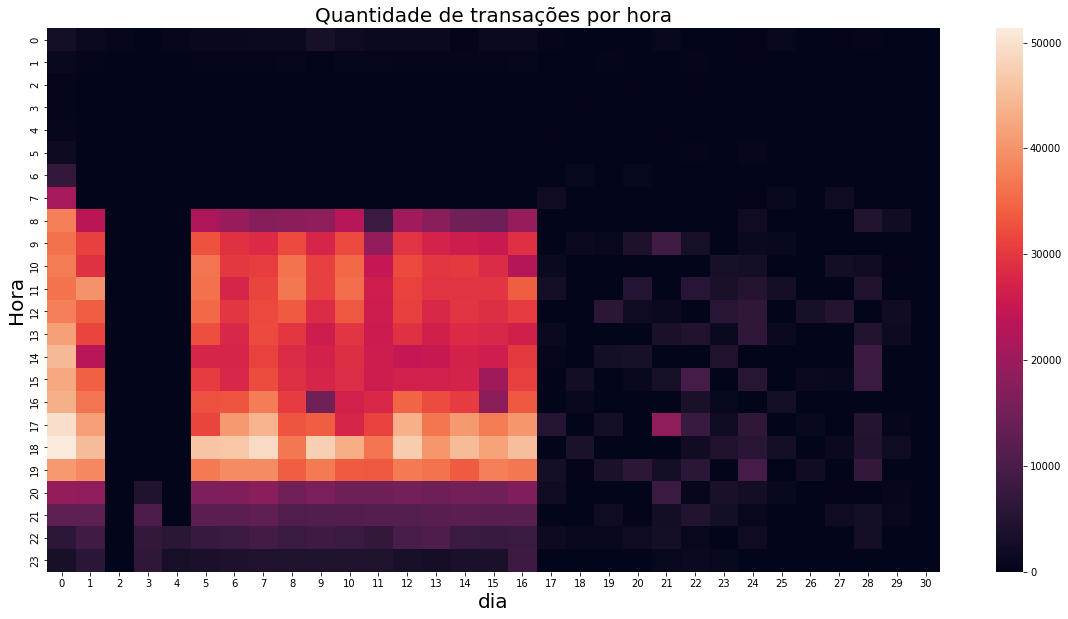

In [11]:
stepAmounts = data.groupby('step').size().array
stepAmounts = numpy.array(stepAmounts, dtype=object)
stepAmounts = numpy.append(stepAmounts, 0)  # Falta 1 hora para completar 31 dias
stepAmounts = stepAmounts.reshape(int(numpy.ceil(len(stepAmounts)/24)), 24)
stepAmounts = stepAmounts.astype(float)

fig, ax = plt.subplots(figsize=(20, 10))
ax = seaborn.heatmap(stepAmounts.T)
ax.set_ylabel('Hora', fontsize=20)
ax.set_xlabel('dia', fontsize=20)
ax.set_title('Quantidade de transações por hora', fontsize=20)
fig.savefig('transacoes_por_hora.jpg')

In [12]:
expected = 1
for i in fraud_transactions.groupby('step').size().keys():
    if i != expected:
        print('Não houve fraude na hora: ', expected)
    expected = i+1

Não houve fraude na hora:  347
Não houve fraude na hora:  545


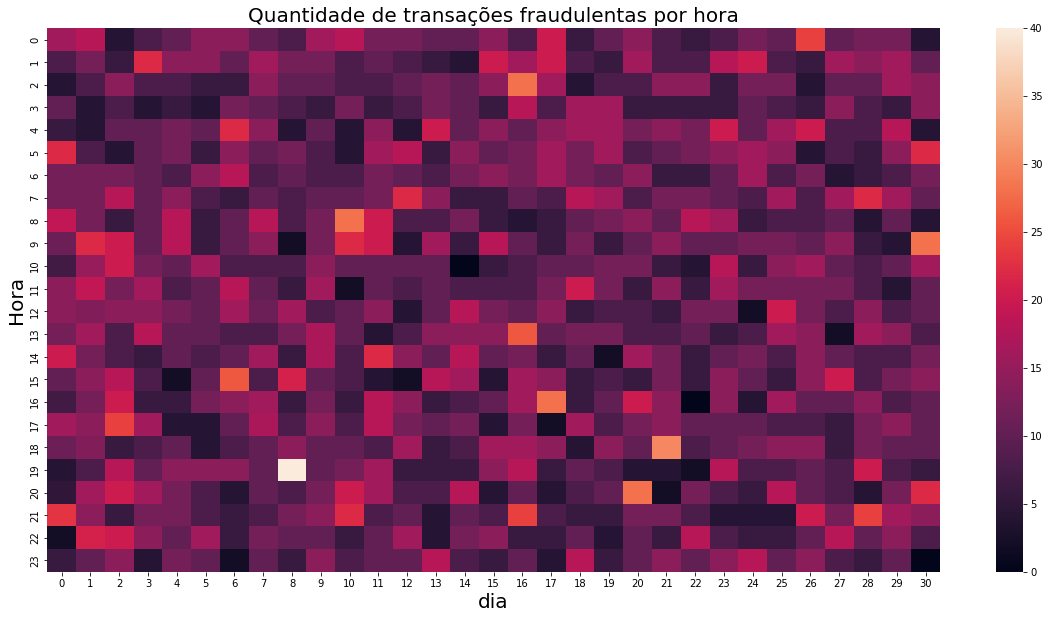

In [13]:
stepAmounts = fraud_transactions.groupby('step').size().array
stepAmounts = numpy.array(stepAmounts, dtype=object)
stepAmounts = numpy.insert(stepAmounts, 346, 0) # Não há fraude na hora 347
stepAmounts = numpy.insert(stepAmounts, 544, 0) # Não há fraude na hora 545
stepAmounts = numpy.append(stepAmounts, 0)      # Falta 1 hora para completar 31 dias
stepAmounts = stepAmounts.reshape(int(numpy.ceil(len(stepAmounts)/24)), 24)
stepAmounts = stepAmounts.astype(float)

fig, ax = plt.subplots(figsize=(20, 10))
ax = seaborn.heatmap(stepAmounts.T)
ax.set_ylabel('Hora', fontsize=20)
ax.set_xlabel('dia', fontsize=20)
ax.set_title('Quantidade de transações fraudulentas por hora', fontsize=20)
fig.savefig('transacoes_fraudulentas_por_hora.jpg')

Podemos ver que os primeiros 17 dias com exceção do terceiro, quarto e quinto dias ocorrem muitas transações por volta dos mesmos horários. No entanto, quando olhamos só para transações fraudulentas, vemos que estão distribuídas de maneira bastante uniforme. 
Logo, a coluna `step` não oferece nenhuma informação quanto se uma dada transferência é fraudulenta ou não.


No entanto, essa informação poderá ser importante no momento de escolher dados de entrada para o algoritmo de solução, logo removeremos essa coluna posteriormente.

### Relação de `type` com `isFraud`

Nesta etapa iremos avaliar a relação dos tipos de operação e as ocorrências de fraudes.


Inicialmente, descobrimos os tipos de operações existentes na base de dados, e em seguida verificamos a quantidade de ocorrência de fraudes para cada tipo encontrado:

In [14]:
transactionTypes = list(dict.fromkeys(data['type']))

for type in transactionTypes:
    print("Fraudes ocorridas como", type, ":", len(fraud_transactions.loc[fraud_transactions['type'].str.match(type)]))

Fraudes ocorridas como PAYMENT : 0
Fraudes ocorridas como TRANSFER : 4097
Fraudes ocorridas como CASH_OUT : 4116
Fraudes ocorridas como DEBIT : 0
Fraudes ocorridas como CASH_IN : 0


Apenas dois dos cinco tipos ocorrem fraudes: **TRANSFER** e **CASH_OUT**.

In [ ]:
transfer_amount = len(data.loc[data['type'].str.match('TRANSFER')])
cashout_amount = len(data.loc[data['type'].str.match('CASH_OUT')])
cashin_amount = len(data.loc[data['type'].str.match('CASH_IN')])
debit_amount = len(data.loc[data['type'].str.match('DEBIT')])
payment_amount = len(data.loc[data['type'].str.match('PAYMENT')])

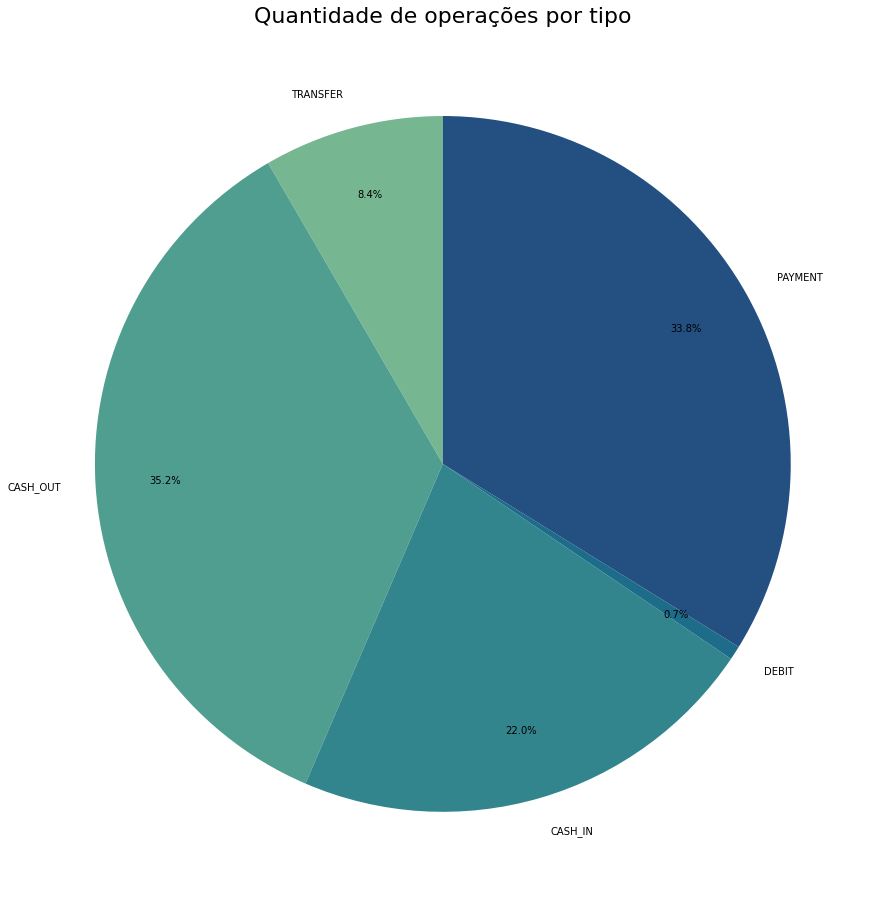

In [37]:
data = [transfer_amount, cashout_amount, cashin_amount, debit_amount, payment_amount]
labels = ['TRANSFER', 'CASH_OUT', 'CASH_IN', 'DEBIT', 'PAYMENT']
colors = seaborn.color_palette('crest', n_colors=5)

fig, ax = plt.subplots(figsize=(16, 16))
ax.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.8, labeldistance=1.1)
ax.set_title('Quantidade de operações por tipo', fontsize=22)
fig.savefig('tipos_de_operacoes.jpg')
plt.show()

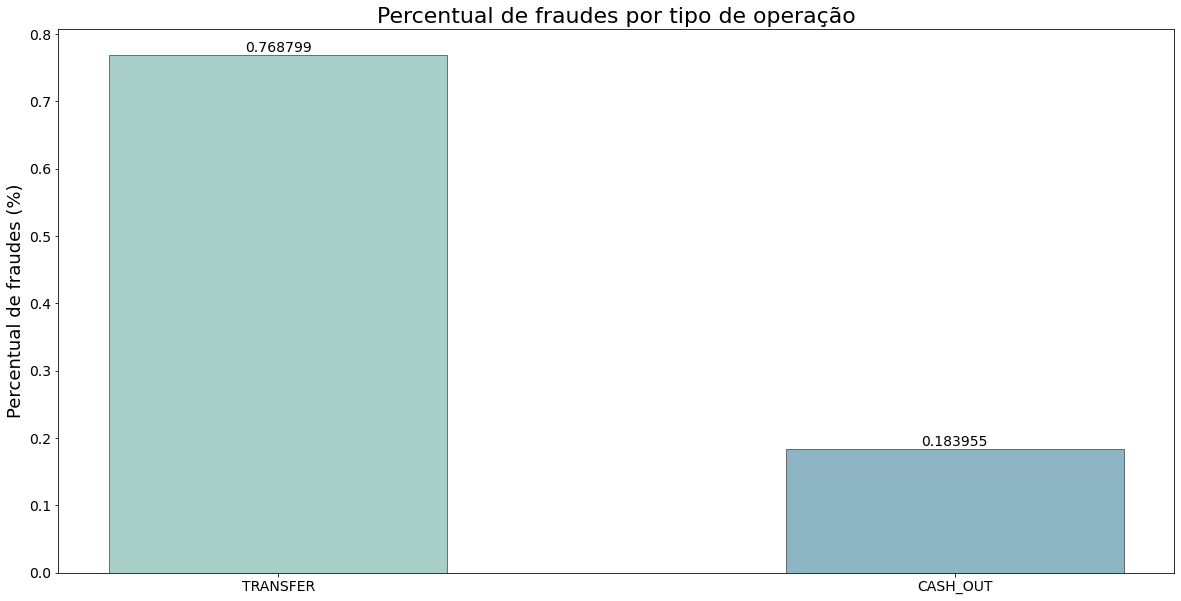

In [25]:
x_data = ['TRANSFER', 'CASH_OUT']
y_data = [4097*100/transfer_amount, 4116*100/cashout_amount]
colors = seaborn.color_palette('crest', n_colors=2)

fig, ax = plt.subplots(figsize=(20, 10))
bar = ax.bar(x_data, y_data, color=colors, width=0.5, align='center', alpha=0.5, edgecolor='black')
ax.bar_label(bar, fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Percentual de fraudes por tipo de operação', fontsize=22)
ax.set_ylabel('Percentual de fraudes (%)', fontsize=18)
fig.savefig('percentual_fraudes_por_tipo_operacao.jpg')
plt.show()

Observamos que cerca 43.6% das operações são dos tipos **TRANSFER** e **CASH_OUT**, das quais um baixo percentual destas contém fraudes, isso pode ser um problema para seleção de dados de entrada. 

Faremos a seguinte simplificação na coluna `type` uma vez que apenas 2 dos tipos de transação apresentam fraudes:
* TRANSFER = 1
* CASH_OUT = 2
* DEBIT, CASH_IN, PAYMENT = 0

In [16]:
conditions = [data['type'].str.match('TRANSFER'), 
              data['type'].str.match('CASH_OUT'), 
              (data['type'].str.match('DEBIT')) | (data['type'].str.match('CASH_IN')) | (data['type'].str.match('PAYMENT'))]
choices    = [1, 2, 0]
reduced_data['simplified_type'] = numpy.select(conditions, choices)
reduced_data = reduced_data.drop(columns=['type'])
reduced_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hasMerchantAccount,simplified_type
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,2
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0


Em adição, a coluna `isFlaggedFraud` apresenta informação redundante. Portanto, também iremos removê-la da tabela.

In [17]:
reduced_data = reduced_data.drop(columns=['isFlaggedFraud'])
reduced_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hasMerchantAccount,simplified_type
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,2
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,1,0


In [19]:
reduced_data.to_csv('reduced_data.csv', index=False)

Exportamos a tabela resultante, e podemos seguir para a etapa de solução do problema.